In [1]:
import numpy as np
import xarray as xr
import dask.array as da 
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from ad99 import AlexanderDunkerton1999
from constants import GRAV,R_DRY,C_P

In [2]:
ds = xr.open_dataset('data/atmos_daily.nc',chunks={'time':1})
ds_mask_trop = xr.open_dataset('data/loon_masks.nc')
ds_mask_trop['lon'] = (ds_mask_trop.lon + 360) % 360 
ds_mask_trop = ds_mask_trop.sortby('lon')
interp_mask = ds_mask_trop.interp(lat=ds.lat,lon=ds.lon,method='nearest').astype(bool)

ocean_expac = ds.where(interp_mask.extratropical_pacific).stack(points = ['lat','lon'])
ocean_expac = ocean_expac.dropna('points',how='all')
ocean_expac = ocean_expac.isel(pfull=slice(None,None,-1))

ocean_expac = ocean_expac[['ucomp','temp','vcomp','height','gwfu_cgwd','gwfv_cgwd']]
ocean_expac = ocean_expac.transpose('time','points','pfull')

dTdz = da.gradient(ocean_expac.temp,axis=-1)/da.gradient(ocean_expac.height,axis=-1)
Ns2 = GRAV/ocean_expac.temp*(dTdz + GRAV/C_P) 
bflim = 1e-4 
Ns2 = xr.where(Ns2 < bflim**2,bflim**2,Ns2)
Ns = da.sqrt(Ns2)
rho = (100*ocean_expac.pfull.data[None,None,:])/(R_DRY*ocean_expac.temp)

/Users/robcking/miniconda3/envs/loon_gw/lib/python3.12/site-packages/dask/_task_spec.py:745: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/Users/robcking/miniconda3/envs/loon_gw/lib/python3.12/site-packages/dask/_task_spec.py:745: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/Users/robcking/miniconda3/envs/loon_gw/lib/python3.12/site-packages/dask/_task_spec.py:745: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [3]:
rho = rho.data
u = ocean_expac.ucomp.data
z = ocean_expac.height.data
Ns = Ns.data

### vectorized dask attempt

In [22]:
source_level_height = 9000
dc = 1.2
idx_z_source = da.argmin(da.abs(z - source_level_height),axis=-1,keepdims=True)

def take_along_axis(data,idx):
    return np.take_along_axis(data[0],idx[0],axis=-1).squeeze(axis=-1)

rho_0 = da.blockwise(take_along_axis,"ij",rho,"ijk",idx_z_source,"ijk",dtype=rho.dtype)
u_0 = da.blockwise(take_along_axis,"ij",u,"ijk",idx_z_source,"ijk",dtype=u.dtype)
c0 = np.arange(-99.6,99.6+dc,dc,dtype=np.float32)

In [23]:
Bm = 0.4
cw = 35

def source_spectrum( c, u=None):
    c = c - u
    return np.sign(c) * Bm *np.exp(-np.log(2) * (c /cw) ** 2)

spectrum = source_spectrum(c0,u_0[...,None])

In [24]:
dz = z[...,1:] - z[...,:-1]  # No need for da.zeros_like
H = -dz / np.log(rho[...,1:] / rho[...,:-1])

# Optionally pad the first element (since slicing shortens the array)
dz = da.concatenate([dz[...,0,None], dz], axis=-1)
H  = da.concatenate([H[...,0,None], H], axis=-1)
H = H.rechunk(z.chunks)
dz = dz.rechunk(z.chunks)

In [25]:
kwv = (2*np.pi)/(300e3)
def reflection_frequency(N,H):
    alpha = 1/(2*H)
    return np.sqrt( N**2 * kwv**2/ (kwv**2 + alpha*alpha))

f = reflection_frequency(Ns,H)


In [26]:
intrinsic_freq = kwv*(c0[:,None] - u[...,None,:])

In [27]:
np.abs(intrinsic_freq)[0,0].compute()

array([[0.00192318, 0.00190597, 0.00197546, ..., 0.00261583, 0.00244588,
        0.00226399],
       [0.00189805, 0.00188084, 0.00195032, ..., 0.0025907 , 0.00242075,
        0.00223886],
       [0.00187292, 0.0018557 , 0.00192519, ..., 0.00256557, 0.00239561,
        0.00221373],
       ...,
       [0.00219858, 0.00221579, 0.0021463 , ..., 0.00150593, 0.00167588,
        0.00185776],
       [0.00222371, 0.00224092, 0.00217144, ..., 0.00153106, 0.00170101,
        0.0018829 ],
       [0.00224884, 0.00226605, 0.00219657, ..., 0.00155619, 0.00172614,
        0.00190803]], dtype=float32)

In [28]:

Fs0 = 3e-3
def intermittency(rho_source, u=None):
    return (Fs0 * dc) / (
        rho_source * da.sum(da.abs(source_spectrum(c0, u[...,None]))*dc, axis=-1)
    )

eps = intermittency(rho_0,u_0)



In [29]:
intrinsic_freq[0,0].compute()

array([[-0.00192318, -0.00190597, -0.00197546, ..., -0.00261583,
        -0.00244588, -0.00226399],
       [-0.00189805, -0.00188084, -0.00195032, ..., -0.0025907 ,
        -0.00242075, -0.00223886],
       [-0.00187292, -0.0018557 , -0.00192519, ..., -0.00256557,
        -0.00239561, -0.00221373],
       ...,
       [ 0.00219858,  0.00221579,  0.0021463 , ...,  0.00150593,
         0.00167588,  0.00185776],
       [ 0.00222371,  0.00224092,  0.00217144, ...,  0.00153106,
         0.00170101,  0.0018829 ],
       [ 0.00224884,  0.00226605,  0.00219657, ...,  0.00155619,
         0.00172614,  0.00190803]], dtype=float32)

In [30]:
level_idx = da.broadcast_to(da.arange(z.shape[-1]),z.shape,chunks=z.chunks) 
tir =(da.abs(intrinsic_freq) >= f[...,None,:])*((level_idx >= idx_z_source)[...,None,:])
tir_idx = da.where(tir.any(axis=-1,keepdims=True) , da.argmax(tir,axis=-1,keepdims=True), tir.shape[-1])


In [31]:
Q0 = 2*Ns[...,None,:]*spectrum[...,:,None]*rho_0[...,None,None]/(rho[...,None,:]*kwv*(c0[...,:,None] - u[...,None,:])**3)
valid_starting = ((idx_z_source == level_idx)[...,None,:]*(Q0 < 1)).any(axis=-1,keepdims=True)
Q0breaking = (Q0 >= 1)*(level_idx > idx_z_source)[...,None,:]*valid_starting

In [32]:
breaking_idx = da.where(Q0breaking.any(axis=-1,keepdims=True), da.argmax(Q0breaking,axis=-1,keepdims=True), Q0.shape[-1] -1 )
breaking_idx = da.where(breaking_idx < tir_idx, breaking_idx, -1)
breaking = (breaking_idx == level_idx[...,None,:])

In [33]:
F0 = da.sum(breaking*rho_0[...,None,None] * spectrum[...,None],axis=-2)
rho_half = da.concatenate([rho_0[...,None],np.sqrt(rho[...,1:]*rho[...,:-1])],axis=-1)
half_lvl_drag = F0 * eps[...,None]/ (rho_half * dz)
full_lvl_drag = da.concatenate([0.5*(half_lvl_drag[...,1:] + half_lvl_drag[...,:-1]),half_lvl_drag[...,-1][...,None]],axis=-1)
full_lvl_drag = full_lvl_drag.rechunk(z.chunks)


In [34]:
fd = full_lvl_drag.compute()

## dask aware! ad99

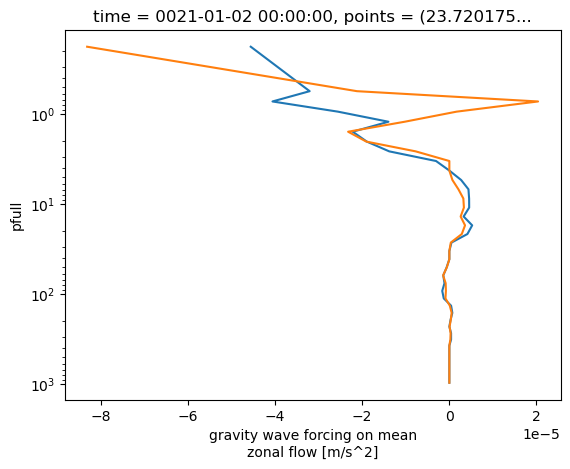

In [35]:
ax = plt.axes()
point = (0,43)
ocean_expac.gwfu_cgwd[*(point)].plot(ax=ax,y='pfull',yincrease=False,yscale='log')
ax.plot(fd[*(point)],ocean_expac.pfull.data)


In [275]:
drag = ocean_expac.sel(pfull=0.2,method='nearest').gwfu_cgwd.compute().data

In [276]:
ptvdrag = drag[drag > 0]

(array([4.335e+03, 4.535e+03, 4.571e+03, 4.388e+03, 4.201e+03, 4.135e+03,
        4.102e+03, 3.884e+03, 3.902e+03, 3.922e+03, 3.807e+03, 3.764e+03,
        3.862e+03, 3.830e+03, 3.749e+03, 3.779e+03, 3.614e+03, 3.673e+03,
        3.639e+03, 3.690e+03, 3.657e+03, 3.493e+03, 3.544e+03, 3.445e+03,
        3.389e+03, 3.265e+03, 3.218e+03, 3.064e+03, 3.016e+03, 2.813e+03,
        2.733e+03, 2.624e+03, 2.534e+03, 2.418e+03, 2.305e+03, 2.172e+03,
        2.030e+03, 1.831e+03, 1.812e+03, 1.732e+03, 1.577e+03, 1.521e+03,
        1.348e+03, 1.231e+03, 1.158e+03, 1.059e+03, 9.590e+02, 8.680e+02,
        8.160e+02, 7.610e+02, 7.340e+02, 7.010e+02, 6.550e+02, 6.010e+02,
        4.900e+02, 4.980e+02, 4.550e+02, 4.660e+02, 4.060e+02, 3.570e+02,
        3.090e+02, 3.020e+02, 2.430e+02, 2.150e+02, 1.770e+02, 1.700e+02,
        1.530e+02, 1.490e+02, 1.430e+02, 1.160e+02, 9.600e+01, 9.100e+01,
        7.400e+01, 6.500e+01, 5.800e+01, 6.000e+01, 4.600e+01, 3.600e+01,
        3.200e+01, 3.700e+01, 1.800e+0

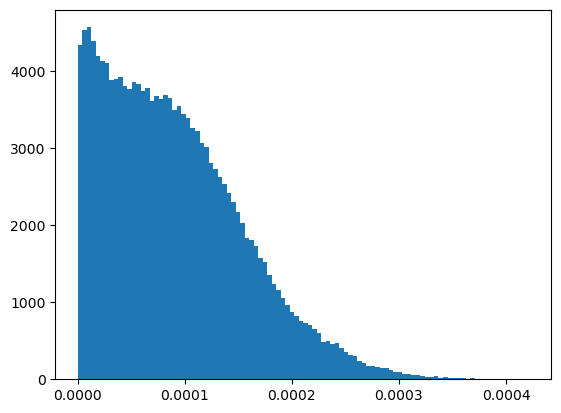

In [277]:
plt.hist(ptvdrag.ravel(),bins=100)

(array([1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 2.0000e+00, 5.0000e+00, 4.0000e+00,
        2.0000e+00, 5.0000e+00, 4.0000e+00, 8.0000e+00, 2.0000e+00,
        5.0000e+00, 9.0000e+00, 6.0000e+00, 1.1000e+01, 1.3000e+01,
        2.0000e+01, 1.6000e+01, 1.3000e+01, 1.8000e+01, 1.7000e+01,
        1.7000e+01, 3.4000e+01, 3.4000e+01, 3.6000e+01, 4.0000e+01,
        3.8000e+01, 4.1000e+01, 3.9000e+01, 6.8000e+01, 5.9000e+01,
        8.1000e+01, 7.6000e+01, 7.8000e+01, 1.0000e+02, 1.2500e+02,
        1.4300e+02, 1.5700e+02, 1.6400e+02, 2.0900e+02, 2.1700e+02,
        2.3700e+02, 3.0500e+02, 2.9500e+02, 3.3000e+02, 4.1000e+02,
        4.6600e+02, 5.1400e+02, 6.2600e+02, 6.8500e+02, 7.4000e+02,
        8.2100e+02, 1.0120e+03, 1.0860e+03, 1.2650e+03, 1.3380e+03,
        1.6110e+03, 1.7520e+03, 1.9120e+03, 2.10

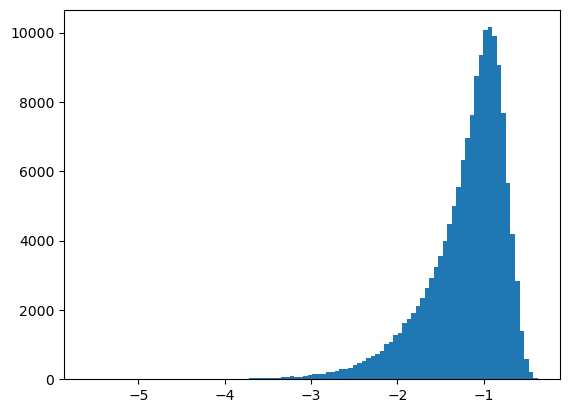

In [278]:
plt.hist(np.log10(1000*ptvdrag),bins=100)